# Execise 3.4 (Orbit Perturbations)

In [19]:
using NBInclude
using Dates
using LinearAlgebra,Plots
using OrdinaryDiffEq
using IRKGaussLegendre

@nbinclude("./SAT_Force.ipynb")
@nbinclude("./SAT_Time.ipynb")
@nbinclude("./SAT_Kepler.ipynb")
@nbinclude("./SAT_RefSys.ipynb")

IERS_UT1_UTC (generic function with 1 method)

- Satellite Orbits (115.pg)

The orbit perturbations due to the non-spherical gravity field of the Earth, the third-body forces of the Sun and the Moon,as well as the solar radiation pressure and the atmospheric drag are to be evaluated. To this end, the equations of motion of the satellite are to be numerically integrated for a reference (truth) orbit that takes into account all relevant perturbations and is based on a gravity model of the Earth complete to order and degree 20. To compute the orbit perturbations, the satellite position using a restricted force model with individual perturbations switched off is computed and the difference with respect to the reference trajectory is derived.

### Accel

In [36]:
function f_sat!(du,u,p,t)
"""
 Purpose:
    Computes the acceleration of an Earth orbiting satellite due to 
    - the Earth's harmonic gravity field
    - the gravitational perturbations of the Sun and Moon
    - the solar radiation pressure and
    - the atmospheric drag

 Input:
    Mjd_TT      Terrestrial Time (Modified Julian Date)
    r           Satellite position vector in the ICRF/EME2000 system
    v           Satellite velocity vector in the ICRF/EME2000 system
    Area        Cross-section
    mass        Spacecraft mass
    CR          Radiation pressure coefficient
    CD          Drag coefficient
  
 Output:
    Acceleration (a=d^2r/dt^2) in the ICRF/EME2000 system
"""    
  Mjd0_TT=p[1]
  Area=p[2]
  mass=p[3]
  CR=p[4]
  CD=p[5]
  n=Int(p[6])    
  m=Int(p[7])    
  FlagSun=Bool(p[8])
  FlagMoon=Bool(p[9])
  FlagSRad=Bool(p[10])
  FlagDrag=Bool(p[11])   
    
       
  r=u[1:3]
  v=u[4:6]

  r_Sun=zeros(3) 
  r_Moon=zeros(3)
  T=zeros(3,3)
  E=zeros(3,3)
    
    
  du[1:3]=v

#  Mjd_TT      Terrestrial Time (Modified Julian Date)    
#  Mjd_TT = (*p).Mjd0_TT + t/86400.0  
   Mjd_TT=Mjd0_TT+t/86400.0

#  Acceleration due to harmonic gravity field
#  Mjd_UT1 = Mjd_TT + (IERS::UT1_UTC(Mjd_TT)-IERS::TT_UTC(Mjd_TT))/86400.0;
  Mjd_UT1 = Mjd_TT + (IERS_UT1_UTC(Mjd_TT,UT1_TAI_,UTC_TAI_)-IERS_TT_UTC(Mjd_TT,UTC_TAI_))/86400.0
  T = NutMatrix(Mjd_TT)*PrecMatrix(MJD_J2000,Mjd_TT)
  E = GHAMatrix(Mjd_UT1)*T
  
#  println("r=",r,",E=",E)

#  du = AccelHarmonic (r,E,Grav.GM,Grav.R_ref,Grav.CS,n,m)
  du[4:6] = AccelHarmonic(r,E,GravJGM3.GM,GravJGM3.R,GravJGM3.CS,n,m)  
    
#  println("AccelHarmonic=",du[4:6])
    

# Luni-solar perturbations 

  Sun!(r_Sun,Mjd_TT)
  Moon!(r_Moon,Mjd_TT)

  if (FlagSun)  du[4:6] += AccelPointMass( r, r_Sun,  GM_Sun  ) end
#  println("FlagSun=",AccelPointMass( r, r_Sun,  GM_Sun  ))
  if (FlagMoon) du[4:6] += AccelPointMass( r, r_Moon, GM_Moon ) end
#  println("FlagMoon=",AccelPointMass( r, r_Moon, GM_Moon ))


# Solar radiation pressure

  if (FlagSRad) du[4:6] += AccelSolrad(r,r_Sun,Area,mass,CR,P_Sol,AU) end
#  println("FlagSRad=",AccelSolrad(r,r_Sun,Area,mass,CR,P_Sol,AU))

# Atmospheric drag

  if (FlagDrag) du[4:6] += AccelDrag( Mjd_TT, r, v, T, Area, mass, CD ) end
#  println("FlagDrag=",AccelDrag( Mjd_TT, r, v, T, Area, mass, CD ))

# Acceleration
  
  return du

end

f_sat! (generic function with 1 method)

## Esperimentua

In [28]:
N_JGM3 = 20
GM_Earth = 398600.4415e+9 
R_JGM3 = 6378.1363e3   # // Radius Earth [m]; 
CS_JGM3=zeros(N_JGM3+1,N_JGM3+1)
CS_JGM3!(CS_JGM3,Float64)

GravJGM3=GravModel{Float64}(N_JGM3,GM_Earth,R_JGM3,CS_JGM3)

GravModel{Float64}(20, 3.986004415e14, 6.3781363e6, [1.0 0.0 … 7.160542e-11 2.759192e-9; 0.0 0.0 … -1.008909e-10 3.216826e-10; … ; -2.197334e-8 -3.156695e-9 … -9.155723e-31 -1.237749e-31; 1.203146e-7 3.688524e-9 … -1.878413e-31 4.054696e-32])

### Initialize UT1-UTC and UTC-TAI time difference

In [29]:
#IERS::Set ( -0.05,-30.00, 0.0, 0.0 );
UT1_TAI_ = -0.05-30.00
UTC_TAI_ = -30.00
x_pole_  = 0.0/Arcs
y_pole_  = 0.0/Arcs;

### Remote sensing satellite

In [30]:
Mjd0_UTC = Mjd(1999,3,1,0,0,0.0)
Kep=[7178.0e3, 0.0010, 98.57*Rad, 0.0, 0.0, 0.0]
Y0=State(GM_Earth, Kep, 0.0 )

6-element Array{Float64,1}:
     7.170822e6
     0.0
     0.0
     0.0
 -1111.575722555183
  7376.070926571781

In [31]:
#Mjd0_TT = Mjd0_UTC+ IERS::TT_UTC(Mjd0_UTC)/86400.0;  
Mjd0_TT = Mjd0_UTC+IERS_TT_UTC(Mjd0_UTC,UTC_TAI_)/86400
Area = 5.0     # [m^2]  Remote sensing satellite
mass = 1000.0  # [kg]
CR   = 1.3
CD   = 2.3

Sun  = true
Moon = true
SRad = true
Drag = true;

In [34]:
Step =  120.0  # [s]
N_Step1 =50   # 100 mins
N_Step2 =720  # 1 day


#Eph_Ref = Array{typeof(Y0)}(undef, N_Step+1)
#Ephemeris(Y0, N_Step2, Step, p, Eph_Ref )

t0=0.
t1=Step*N_Step2
t1=Step*N_Step1
tspan=(t0,t1)

(0.0, 6000.0)

### Orbits

In [37]:
# reference orbit
n=20
m=20

n=10
m=10
p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag];

prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_RS=solve(prob,dt=Step,RK4(),adaptive=true,abstol=1.e-6,reltol=1.e-13,saveat=Step)
sol_RS.destats;

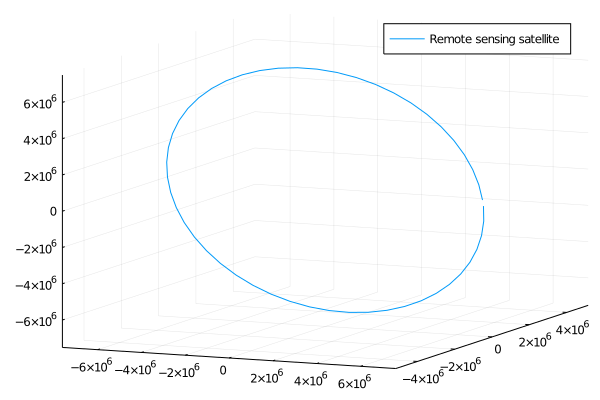

In [83]:
x=[u[1] for u in sol_RS.u]
y=[u[2] for u in sol_RS.u]
z=[u[3] for u in sol_RS.u]
plot(x,y,z, label="Remote sensing satellite",aspect_ratio=true)

In [84]:
# J2,0 perturbations
n=2
m=0

p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag]

prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_RS1=solve(prob,dt=Step,RK4(),adaptive=true,abstol=1.e-6,reltol=1.e-13,saveat=Step)

# J2,2 perturbations
n=2
m=2

p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag]

prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_RS2=solve(prob,dt=Step,RK4(),adaptive=true,abstol=1.e-6,reltol=1.e-13,saveat=Step)


# J4,4 perturbations
n=4
m=4

p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag]

prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_RS3=solve(prob,dt=Step,RK4(),adaptive=true,abstol=1.e-6,reltol=1.e-13,saveat=Step)


# J10,10 perturbations
n=10
m=10
p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag];

prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_RS4=solve(prob,dt=Step,RK4(),adaptive=true,abstol=1.e-6,reltol=1.e-13,saveat=Step)

n=20
m=20

# Solar perturbations
Sun  = false
p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag]
prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_RS5=solve(prob,dt=Step,RK4(),adaptive=true,abstol=1.e-6,reltol=1.e-13,saveat=Step)
Sun  = true


# Lunar perturbations
Moon  = false
p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag]
prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_RS6=solve(prob,dt=Step,RK4(),adaptive=true,abstol=1.e-6,reltol=1.e-13,saveat=Step)
Moon  = true

# Solar radiation pressure perturbations
SRad = false
p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag]
prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_RS7=solve(prob,dt=Step,RK4(),adaptive=true,abstol=1.e-6,reltol=1.e-13,saveat=Step)
SRad = true


# Drag perturbations
Drag = false
p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag]
prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_RS8=solve(prob,dt=Step,RK4(),adaptive=true,abstol=1.e-6,reltol=1.e-13,saveat=Step)
Drag = true;

In [85]:
d1=maximum(map((u,ux) -> norm(u[1:3]-ux[1:3]), sol_RS.u,sol_RS1.u))
d2=maximum(map((u,ux) -> norm(u[1:3]-ux[1:3]), sol_RS.u,sol_RS2.u))
d3=maximum(map((u,ux) -> norm(u[1:3]-ux[1:3]), sol_RS.u,sol_RS3.u))
d4=maximum(map((u,ux) -> norm(u[1:3]-ux[1:3]), sol_RS.u,sol_RS4.u))
d5=maximum(map((u,ux) -> norm(u[1:3]-ux[1:3]), sol_RS.u,sol_RS5.u))
d6=maximum(map((u,ux) -> norm(u[1:3]-ux[1:3]), sol_RS.u,sol_RS6.u))
d7=maximum(map((u,ux) -> norm(u[1:3]-ux[1:3]), sol_RS.u,sol_RS7.u))
d8=maximum(map((u,ux) -> norm(u[1:3]-ux[1:3]), sol_RS.u,sol_RS8.u))
[d1 d2 d3 d4 d5 d6 d7 d8]

1×8 Array{Float64,2}:
 641.489  353.951  297.939  10.0918  2.86383  6.02281  0.992361  0.391978

In [69]:
#Nire erantzunak:
#  1-rev:   641.561  354.002  297.928  10.1286  2.86382  6.02292  0.992356  0.394891
#  1-day:  13256.1  10802.6  3565.71  445.081  33.7761  65.9877  13.9039  103.417

# Liburuko erantzunak
#  1- rev   600.1   223.6   147.5    22.7     2.9     6.0     1.0     0.5
#  1- day  5028.4  3038.2  1924.7   458.9    33.8    65.9    13.9   104.5

###  Geostationary satellite


In [88]:
Mjd0_UTC = Mjd(1999,3,1,0,0,0.0)
Kep=[42166.0e3, 0.0004, 0.02*Rad, 0.0, 0.0, 0.0]
Y0=State(GM_Earth, Kep, 0.0 );

In [100]:
Mjd0_TT = Mjd0_UTC+IERS_TT_UTC(Mjd0_UTC,UTC_TAI_)/86400
Area = 10.0     # [m^2]  Geostationary satellite
mass = 1000.0  # [kg]
CR   = 1.3
CD   = 2.3
n    = 20
m    = 20
Sun  = true
Moon = true
SRad = true
Drag = true

p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag];

In [101]:
Step =  1200.0  # [s]
N_Step1 = 72   # 1 day
N_Step2 = 144  # 2 days

t0=0.
t1=Step*N_Step2
t1=Step*N_Step1
tspan=(t0,t1)
prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_GS=solve(prob,dt=Step,RK4(),adaptive=true,abstol=1.e-6,reltol=1.e-13,saveat=Step)
sol_GS.destats;

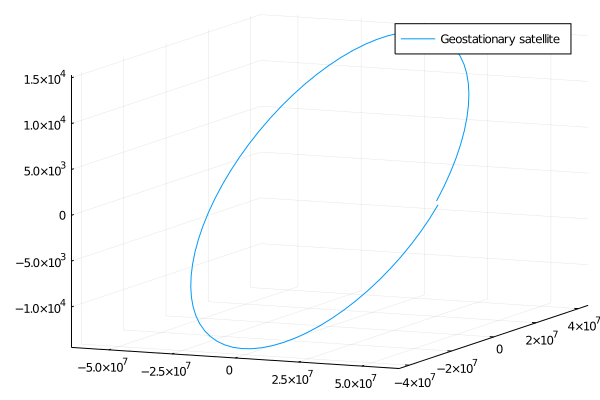

In [102]:
x=[u[1] for u in sol_GS.u]
y=[u[2] for u in sol_GS.u]
z=[u[3] for u in sol_GS.u]
plot(x,y,z,label="Geostationary satellite",aspect_ratio=true)

In [103]:
# J2,0 perturbations
n=2
m=0

p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag]

prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_GS1=solve(prob,dt=Step,RK4(),adaptive=true,abstol=1.e-6,reltol=1.e-13,saveat=Step)

# J2,2 perturbations
n=2
m=2

p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag]

prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_GS2=solve(prob,dt=Step,RK4(),adaptive=true,abstol=1.e-6,reltol=1.e-13,saveat=Step)


# J4,4 perturbations
n=4
m=4

p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag]

prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_GS3=solve(prob,dt=Step,RK4(),adaptive=true,abstol=1.e-6,reltol=1.e-13,saveat=Step)


# J10,10 perturbations
n=10
m=10
p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag];

prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_GS4=solve(prob,dt=Step,RK4(),adaptive=true,abstol=1.e-6,reltol=1.e-13,saveat=Step)

n=20
m=20

# Solar perturbations
Sun  = false
p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag]
prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_GS5=solve(prob,dt=Step,RK4(),adaptive=true,abstol=1.e-6,reltol=1.e-13,saveat=Step)
Sun  = true


# Lunar perturbations
Moon  = false
p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag]
prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_GS6=solve(prob,dt=Step,RK4(),adaptive=true,abstol=1.e-6,reltol=1.e-13,saveat=Step)
Moon  = true

# Solar radiation pressure perturbations
SRad = false
p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag]
prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_GS7=solve(prob,dt=Step,RK4(),adaptive=true,abstol=1.e-6,reltol=1.e-13,saveat=Step)
SRad = true


# Drag perturbations
Drag = false
p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag]
prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_GS8=solve(prob,dt=Step,RK4(),adaptive=true,abstol=1.e-6,reltol=1.e-13,saveat=Step)
Drag = true;


In [104]:
d1=maximum(map((u,ux) -> norm(u[1:3]-ux[1:3]), sol_GS.u,sol_GS1.u))
d2=maximum(map((u,ux) -> norm(u[1:3]-ux[1:3]), sol_GS.u,sol_GS2.u))
d3=maximum(map((u,ux) -> norm(u[1:3]-ux[1:3]), sol_GS.u,sol_GS3.u))
d4=maximum(map((u,ux) -> norm(u[1:3]-ux[1:3]), sol_GS.u,sol_GS4.u))
d5=maximum(map((u,ux) -> norm(u[1:3]-ux[1:3]), sol_GS.u,sol_GS5.u))
d6=maximum(map((u,ux) -> norm(u[1:3]-ux[1:3]), sol_GS.u,sol_GS6.u))
d7=maximum(map((u,ux) -> norm(u[1:3]-ux[1:3]), sol_GS.u,sol_GS7.u))
d8=maximum(map((u,ux) -> norm(u[1:3]-ux[1:3]), sol_GS.u,sol_GS8.u))
[d1 d2 d3 d4 d5 d6 d7 d8]

1×8 Array{Float64,2}:
 820.625  8.18083  0.203646  1.49848e-5  3142.57  5111.36  415.026  0.0

In [105]:
# Nire erantzunak
# 1 days: 820.634  8.18132  0.203663  1.36531e-5  3142.55  5110.92  415.025   0.0
# 2 days: 3150.99  42.7675  1.28766   5.17016e-5  4833.7   5499.42  830.171   0.0

# Liburuko erantzunak
# 1 days: 671.2      2.3      0.1         0.0      3142.6   5080.2   415.0    0.0
# 2 days: 2534.8     10.1     0.6         0.0      4833.7   5438.4   830.2    0.0